## Importing required libraries

In [15]:
# ===================== 0) Imports & fixed base path =====================
import warnings, numpy as np, pandas as pd, lightgbm as lgb
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)

# >>> set this to your dataset mount <<<
BASE = Path("/kaggle/input/gq-volt")   # change if your dataset path differs
SAMPLE_SUB = BASE / "submission.csv"

PEER_ASSETS = ["BTC","SOL","DOGE","DOT","LINK","SHIB"]



In [16]:
# ===================== 1) Helpers: timestamp parser & feature builders =====================
def smart_to_datetime(series: pd.Series) -> pd.Series:
    """Parse timestamps robustly: strings or epoch (s/ms) -> UTC datetimes."""
    if pd.api.types.is_datetime64_any_dtype(series):
        return series.dt.tz_localize('UTC') if series.dt.tz is None else series
    num = pd.to_numeric(series, errors='coerce')
    is_num = num.notna()
    out_num = pd.to_datetime(
        num.where(is_num, np.nan),
        unit=('ms' if (is_num.any() and num[is_num].max() > 1e12) else 's'),
        utc=True, errors='coerce'
    )
    out_str = pd.to_datetime(series.where(~is_num, None), utc=True, errors='coerce')
    return out_str.fillna(out_num)

def build_eth_features(df: pd.DataFrame, is_test: bool=False, keep_cols=None):
    df = df.copy()
    df['timestamp'] = smart_to_datetime(df['timestamp'])
    df = df.dropna(subset=['timestamp']).sort_values('timestamp')
    df = df.groupby('timestamp', as_index=False).last()

    # numeric coercion
    num_cols = [c for c in df.columns if c != 'timestamp']
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

    # mid_price guard (safe logs)
    mp = df['mid_price']
    mask = mp.gt(0, fill_value=False) & np.isfinite(mp.values)
    df['mid_price'] = mp.where(mask).ffill().fillna(1e-8)

    for c in ['ask_price1','bid_price1','ask_volume1','bid_volume1',
              'bid_volume2','bid_volume3','bid_volume4','bid_volume5',
              'ask_volume2','ask_volume3','ask_volume4','ask_volume5']:
        if c in df.columns:
            df[c] = df[c].where(np.isfinite(df[c]), np.nan).fillna(0.0)

    # ---- L1 microstructure ----
    df['spread']     = (df['ask_price1'] - df['bid_price1']).fillna(0.0)
    df['rel_spread'] = (df['spread'] / df['mid_price'].replace(0, np.nan)).replace([np.inf,-np.inf], np.nan).fillna(0.0)
    denom_vol = (df['bid_volume1'] + df['ask_volume1']) + 1e-9
    df['imb1']       = (df['bid_volume1'] - df['ask_volume1']) / denom_vol

    # microprice (weighted by opposite side size)
    df['microprice'] = (
        df['ask_price1'] * df['bid_volume1'] + df['bid_price1'] * df['ask_volume1']
    ) / denom_vol

    # queue imbalance variants
    df['qi1'] = (df['bid_volume1'] - df['ask_volume1']) / denom_vol

    # ---- depth across L1–L5 (if present) ----
    lvls = [i for i in range(1,6) if f'bid_volume{i}' in df.columns and f'ask_volume{i}' in df.columns]
    if lvls:
        bcols = [f'bid_volume{i}' for i in lvls]
        acols = [f'ask_volume{i}' for i in lvls]
        df['bid_depth'] = df[bcols].sum(axis=1)
        df['ask_depth'] = df[acols].sum(axis=1)
        dden = (df['bid_depth'] + df['ask_depth']) + 1e-9
        df['depth_imb'] = (df['bid_depth'] - df['ask_depth']) / dden

        # queue imbalance over top-5 (sum of volumes)
        df['qi5'] = (df['bid_depth'] - df['ask_depth']) / dden
    else:
        df['bid_depth'] = 0.0
        df['ask_depth'] = 0.0
        df['depth_imb'] = 0.0
        df['qi5']       = 0.0

    # ---- time-based stats ----
    s = df.set_index('timestamp').sort_index()

    # returns/vols
    log_mid = np.log(s['mid_price'].astype(float)).replace([np.inf,-np.inf], np.nan)
    s['log_ret_1s'] = log_mid.diff().fillna(0.0)
    s['rv10s']      = s['log_ret_1s'].rolling('10s').std().fillna(0.0)
    s['rv30s']      = s['log_ret_1s'].rolling('30s').std().fillna(0.0)
    s['rv60s']      = s['log_ret_1s'].rolling('60s').std().fillna(0.0)

    # momentum & smoothing
    s['ret5s']       = s['mid_price'].pct_change(5, fill_method=None).replace([np.inf,-np.inf], np.nan).fillna(0.0)
    s['spread_ma10'] = s['spread'].rolling('10s').mean().fillna(0.0)
    s['spread_ma30'] = s['spread'].rolling('30s').mean().fillna(0.0)
    s['imb1_ma10']   = s['imb1'].rolling('10s').mean().fillna(0.0)
    s['imb1_ma30']   = s['imb1'].rolling('30s').mean().fillna(0.0)

    # microprice dynamics
    s['micro_ret_1s'] = np.log(s['microprice'].astype(float).clip(lower=1e-8)).diff().fillna(0.0)

    df = s.reset_index()

    # ---- feature set ----
    feature_cols = [
        'mid_price','microprice','spread','rel_spread',
        'imb1','qi1','qi5','bid_depth','ask_depth','depth_imb',
        'log_ret_1s','micro_ret_1s','rv10s','rv30s','rv60s',
        'ret5s','spread_ma10','spread_ma30','imb1_ma10','imb1_ma30'
    ]

    if keep_cols is not None:
        for m in keep_cols:
            if m not in df.columns:
                df[m] = 0.0
        feature_cols = keep_cols

    df[feature_cols] = (
        df[feature_cols]
        .apply(pd.to_numeric, errors='coerce')
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0.0)
    )

    if not is_test:
        if 'label' not in df.columns:
            raise ValueError("Expected 'label' in train/ETH.csv; it's the 10s-ahead IV.")
        return df[['timestamp'] + feature_cols + ['label']], feature_cols
    else:
        return df[['timestamp'] + feature_cols], feature_cols
# ---- Extra microstructure / multi-scale features ----
def add_more_feats(df):
    s = df.set_index('timestamp').sort_index()

    # microprice displacement
    s['micro_disp'] = (s['microprice'] - s['mid_price']) / s['mid_price']

    # range / turbulence
    s['mid_roll_max_10'] = s['mid_price'].rolling('10s').max()
    s['mid_roll_min_10'] = s['mid_price'].rolling('10s').min()
    s['range10']         = (s['mid_roll_max_10'] - s['mid_roll_min_10']) / s['mid_price']
    s['spread_std10']    = s['spread'].rolling('10s').std()

    # change speed
    s['d_spread'] = s['spread'].diff().fillna(0.0)
    s['d_imb1']   = s['imb1'].diff().fillna(0.0)
    s['d_depth']  = (s['bid_depth'] - s['ask_depth']).diff().fillna(0.0)

    # longer vol windows (HAR-ish)
    for w in ['120s','300s']:
        s[f'rv{w}'] = s['log_ret_1s'].rolling(w).std()

    # intraday cycles
    sec = s.index.view('int64') // 10**9
    s['sin_1h'] = np.sin(2*np.pi*(sec % 3600)/3600)
    s['cos_1h'] = np.cos(2*np.pi*(sec % 3600)/3600)

    out = s.reset_index()
    extra = ['micro_disp','range10','spread_std10','d_spread','d_imb1','d_depth','rv120s','rv300s','sin_1h','cos_1h']
    for c in extra:
        if c not in out: out[c] = 0.0
    return out, extra


def make_lob_feats(df: pd.DataFrame) -> pd.DataFrame:
    """Peer features for proxy pretraining (next-10s realized vol)."""
    d = df.copy()
    d['timestamp'] = smart_to_datetime(d['timestamp'])
    d = d.dropna(subset=['timestamp']).sort_values('timestamp')
    d = d.groupby('timestamp', as_index=False).last()

    num_cols = [c for c in d.columns if c != 'timestamp']
    d[num_cols] = d[num_cols].apply(pd.to_numeric, errors='coerce')

    d['mid']   = d['mid_price']
    d['spread']= d['ask_price1'] - d['bid_price1']
    d['rel_spread'] = d['spread'] / d['mid'].replace(0, np.nan)
    d['imb1']  = (d['bid_volume1'] - d['ask_volume1']) / (d['bid_volume1'] + d['ask_volume1'] + 1e-9)

    s = d.set_index('timestamp').sort_index()
    ret1 = np.log(s['mid'].astype(float).clip(lower=1e-8)).diff().fillna(0.0)
    rv10_past = ret1.rolling('10s').std()
    rv10_future = ret1.rolling('10s').std().shift(-10)

    out = pd.DataFrame({
        'timestamp': s.index,
        'mid': s['mid'].values,
        'spread': s['spread'].values,
        'rel_spread': s['rel_spread'].values,
        'imb1': s['imb1'].values,
        'ret1': ret1.values,
        'rv10_past': rv10_past.fillna(0.0).values,
        'rv10_future_proxy': rv10_future.values,
    })
    return out


In [17]:
# ===================== 2) Load ETH supervised & peer proxy data =====================
eth_path = BASE / "train" / "ETH.csv"
assert eth_path.exists(), f"Missing {eth_path}"

train_eth = pd.read_csv(eth_path)

# Build + extend train features
train_fe, base_cols = build_eth_features(train_eth, is_test=False)
train_fe, extra_cols = add_more_feats(train_fe)
feature_cols = base_cols + extra_cols

print("ETH feature columns:", feature_cols)
train_fe.head()


ETH feature columns: ['mid_price', 'microprice', 'spread', 'rel_spread', 'imb1', 'qi1', 'qi5', 'bid_depth', 'ask_depth', 'depth_imb', 'log_ret_1s', 'micro_ret_1s', 'rv10s', 'rv30s', 'rv60s', 'ret5s', 'spread_ma10', 'spread_ma30', 'imb1_ma10', 'imb1_ma30', 'micro_disp', 'range10', 'spread_std10', 'd_spread', 'd_imb1', 'd_depth', 'rv120s', 'rv300s', 'sin_1h', 'cos_1h']


,timestamp,mid_price,microprice,spread,rel_spread,imb1,qi1,qi5,bid_depth,ask_depth,depth_imb,log_ret_1s,micro_ret_1s,rv10s,rv30s,rv60s,ret5s,spread_ma10,spread_ma30,imb1_ma10,imb1_ma30,label,micro_disp,mid_roll_max_10,mid_roll_min_10,range10,spread_std10,d_spread,d_imb1,d_depth,rv120s,rv300s,sin_1h,cos_1h
0,2024-09-25 18:13:28+00:00,2581.605,2581.608979,0.01,0.000004,0.795740,0.795740,0.800225,3361.2,373.0,0.800225,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0,0.01,0.01,0.795740,0.795740,0.000060,1.541173e-06,2581.605,2581.605,0.000000,NaN,0.000000e+00,0.000000,0.0,NaN,NaN,0.987136,0.159881
1,2024-09-25 18:13:29+00:00,2581.285,2581.286344,0.01,0.000004,0.268774,0.268774,0.121436,1533.9,1201.7,0.121436,-0.000124,-1.249821e-04,0.000088,0.000088,0.000088,0.0,0.01,0.01,0.532257,0.532257,0.000057,5.206208e-07,2581.605,2581.285,0.000124,3.215549e-13,-4.547474e-13,-0.526966,-2656.0,0.000088,0.000088,0.987414,0.158158
2,2024-09-25 18:13:30+00:00,2581.285,2581.285201,0.01,0.000004,0.040233,0.040233,-0.107131,957.2,1186.9,-0.107131,0.000000,-4.426892e-07,0.000072,0.000072,0.000072,0.0,0.01,0.01,0.368249,0.368249,0.000080,7.793144e-08,2581.605,2581.285,0.000124,2.625484e-13,0.000000e+00,-0.228541,-561.9,0.000072,0.000072,0.987688,0.156434
3,2024-09-25 18:13:31+00:00,2581.105,2581.107038,0.01,0.000004,0.407600,0.407600,0.320310,2510.9,1292.6,0.320310,-0.000070,-6.902349e-05,0.000060,0.000060,0.000060,0.0,0.01,0.01,0.378087,0.378087,0.000087,7.895832e-07,2581.605,2581.105,0.000194,2.625485e-13,4.547474e-13,0.367367,1448.0,0.000060,0.000060,0.987960,0.154710
4,2024-09-25 18:13:32+00:00,2581.105,2581.107356,0.01,0.000004,0.471174,0.471174,0.347953,2526.4,1222.1,0.347953,0.000000,1.231527e-07,0.000056,0.000056,0.000056,0.0,0.01,0.01,0.396704,0.396704,0.000090,9.127360e-07,2581.605,2581.105,0.000194,2.490755e-13,0.000000e+00,0.063574,86.0,0.000056,0.000056,0.988228,0.152986


In [18]:
# ===================== 3) Build peer proxy pretraining set (optional) =====================
parts = []
for a in PEER_ASSETS:
    p = BASE / "train" / f"{a}.csv"
    if not p.exists():
        continue
    raw = pd.read_csv(p)
    f = make_lob_feats(raw).dropna(subset=['rv10_future_proxy'])
    parts.append(f[['mid','spread','rel_spread','imb1','ret1','rv10_past','rv10_future_proxy']])

if parts:
    pre_df = pd.concat(parts, ignore_index=True).replace([np.inf,-np.inf], np.nan).dropna()
    X_pre = pre_df[['mid','spread','rel_spread','imb1','ret1','rv10_past']].values.astype(float)
    y_pre = pre_df['rv10_future_proxy'].values.astype(float)
    print("Pretraining samples:", X_pre.shape[0])
else:
    X_pre = y_pre = None
    print("No peer datasets found; skipping pretraining.")


Pretraining samples: 0


In [19]:
# ===================== 4) Train with walk-forward CV (Pearson) + final fit =====================
from sklearn.model_selection import TimeSeriesSplit

# --- Purged walk-forward folds (prevents leakage around 10s horizon) ---
def purged_folds(n, n_splits=5, gap=20):
    import numpy as np
    fold_sizes = np.full(n_splits, n // n_splits, dtype=int)
    fold_sizes[: n % n_splits] += 1
    idx = np.arange(n)
    start = 0
    for _ in range(n_splits):
        stop = start + fold_sizes[_]
        val_idx = idx[start:stop]
        tr_left  = idx[: max(0, start - gap)]
        tr_right = idx[min(n, stop + gap):]
        tr_idx = np.concatenate([tr_left, tr_right])
        yield tr_idx, val_idx
        start = stop

# sklearn-style Pearson for LightGBM
def lgb_pearson(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    if y_true.std()<1e-12 or y_pred.std()<1e-12: return ('pearson', 0.0, True)
    return ('pearson', float(np.corrcoef(y_pred, y_true)[0,1]), True)



# ===================== 4) Train with PURGED walk-forward CV (Pearson) + final fit =====================
# (Assumes: build_eth_features done; lgb_pearson() and purged_folds() already defined above)

def pearson_np(y_true, y_pred):
    y_true = np.asarray(y_true, float); y_pred = np.asarray(y_pred, float)
    if y_true.std() < 1e-12 or y_pred.std() < 1e-12: return 0.0
    return float(np.corrcoef(y_pred, y_true)[0, 1])

# Prepare X, y
X = train_fe[feature_cols].values.astype('float32')
y = train_fe['label'].astype('float32').values
row_ok = np.isfinite(y) & np.isfinite(X).all(axis=1)
X, y = X[row_ok], y[row_ok]

# Optional pretraining on pre_features (if you built them)
pre_booster = None
if 'X_pre' in globals() and X_pre is not None and len(X_pre) > 0:
    pre_model = lgb.LGBMRegressor(
        n_estimators=1500, learning_rate=0.05, num_leaves=64,
        subsample=0.9, colsample_bytree=0.9, random_state=42, verbosity=-1, metric="l2"
    )
    pre_model.fit(
        X_pre, y_pre,
        eval_set=[(X_pre, y_pre)],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=0)]
    )
    pre_booster = pre_model.booster_
    print("Pretraining done.")

# ---- PURGED walk-forward CV (gap ~ horizon*2 to avoid leakage) ----
fold_corrs, best_iters = [], []
last_fold = None
last_best_iter = None

for k, (tr_idx, va_idx) in enumerate(purged_folds(len(X), n_splits=5, gap=20), 1):
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    model = lgb.LGBMRegressor(
        n_estimators=4000, learning_rate=0.03, num_leaves=64,
        subsample=0.9, colsample_bytree=0.9, random_state=42,
        verbosity=-1, metric=None
    )
    init_kw = {'init_model': pre_booster} if pre_booster is not None else {}

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric=lgb_pearson,
        callbacks=[lgb.early_stopping(200, verbose=False), lgb.log_evaluation(period=0)],
        **init_kw
    )
    y_hat = model.predict(X_va, num_iteration=model.best_iteration_)
    r = pearson_np(y_va, y_hat)
    fold_corrs.append(r)
    best_iters.append(model.best_iteration_ or 100)
    last_fold = (tr_idx, va_idx)          # save last fold for blending/smoothing later
    last_best_iter = model.best_iteration_
    print(f"Fold {k}: Pearson r = {r:.4f} | best_iter = {model.best_iteration_}")

print(f"\nMean CV Pearson r: {np.mean(fold_corrs):.4f} | Std: {np.std(fold_corrs):.4f}")

best_iter_avg  = int(np.clip(np.mean(best_iters), 100, 4000))
best_iter_last = int(last_best_iter or best_iter_avg)
best_iter_final = best_iter_last          # prefer last fold (closest to test)
print(f"Using best_iter_avg = {best_iter_avg} | best_iter_last = {best_iter_last} -> final = {best_iter_final}")

# ---- Final fit on all ETH (store for quick single-model inference) ----
final_model = lgb.LGBMRegressor(
    n_estimators=best_iter_final, learning_rate=0.03, num_leaves=64,
    subsample=0.9, colsample_bytree=0.9, random_state=42, verbosity=-1, metric=None
)
init_kw = {'init_model': pre_booster} if pre_booster is not None else {}
final_model.fit(X, y, eval_set=[(X, y)], eval_metric=lgb_pearson, callbacks=[lgb.log_evaluation(period=0)], **init_kw)

print("In-sample Pearson (sanity):", pearson_np(y, final_model.predict(X)))


Fold 1: Pearson r = 0.6201 | best_iter = 112
Fold 2: Pearson r = 0.6741 | best_iter = 179
Fold 3: Pearson r = 0.6332 | best_iter = 206
Fold 4: Pearson r = 0.7122 | best_iter = 155
Fold 5: Pearson r = 0.6582 | best_iter = 18

Mean CV Pearson r: 0.6596 | Std: 0.0323
Using best_iter_avg = 134 | best_iter_last = 18 -> final = 18
In-sample Pearson (sanity): 0.7522000526539802


In [20]:
# === Pick final n_estimators on last fold (avoid underfitting at 18) ===
tr_idx, va_idx = last_fold  # saved in the CV cell
X_tr, X_va = X[tr_idx], X[va_idx]
y_tr, y_va = y[tr_idx], y[va_idx]

cands = sorted(set([
    int(last_best_iter or 100),
    int(np.median(best_iters)),
    int(np.mean(best_iters)),
    int(1.25 * np.mean(best_iters)),
]))
# clamp to a sane range
cands = [int(np.clip(c, 50, 800)) for c in cands]

def try_rounds(rounds):
    scores = []
    for r in rounds:
        m = lgb.LGBMRegressor(
            n_estimators=r, learning_rate=0.03, num_leaves=64,
            subsample=0.9, colsample_bytree=0.9, random_state=2025,
            verbosity=-1, metric=None
        )
        m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], eval_metric=lgb_pearson,
              callbacks=[lgb.log_evaluation(period=0)])
        p = m.predict(X_va)
        scores.append((r, float(np.corrcoef(p, y_va)[0,1])))
    return scores

round_scores = try_rounds(cands)
round_scores


[(50, 0.6213304234275834),
 (134, 0.5830988637136082),
 (155, 0.5799279791798324),
 (167, 0.5798513313502405)]

In [21]:
best_iter_final = max(round_scores, key=lambda x: x[1])[0]
print("Chosen final n_estimators:", best_iter_final, "| candidates tested:", cands)


Chosen final n_estimators: 50 | candidates tested: [50, 134, 155, 167]


In [22]:
# === Train two decorrelated configs and bag them ===
CFG_A = dict(learning_rate=0.03, num_leaves=64,  min_child_samples=80,
             subsample=0.9,  colsample_bytree=0.9,  lambda_l2=2.0)
CFG_B = dict(learning_rate=0.02, num_leaves=128, min_child_samples=160,
             subsample=0.85, colsample_bytree=0.85, lambda_l2=8.0)
SEEDS = [29, 42, 73]  # bump to 5 if you have time

def fit_bag(X, y, cfg, seeds, n_estimators):
    bags = []
    for sd in seeds:
        m = lgb.LGBMRegressor(metric=None, n_estimators=n_estimators, random_state=sd, verbosity=-1, **cfg)
        m.fit(X, y, eval_set=[(X, y)], eval_metric=lgb_pearson, callbacks=[lgb.log_evaluation(period=0)])
        bags.append(m)
    return bags

def predict_bags(models, X):
    return np.column_stack([m.predict(X) for m in models]).mean(axis=1)

bags_A = fit_bag(X, y, CFG_A, SEEDS, best_iter_final)
bags_B = fit_bag(X, y, CFG_B, SEEDS, best_iter_final)

# --- Tune blend and smoothing on last fold (closest to test) ---
Xv, yv = X[va_idx], y[va_idx]
pA_v = predict_bags(bags_A, Xv)
pB_v = predict_bags(bags_B, Xv)

best_r, best_w = -1.0, 0.5
for w in np.linspace(0.2, 0.8, 13):
    r = float(np.corrcoef(w*pA_v + (1-w)*pB_v, yv)[0,1])
    if r > best_r: best_r, best_w = r, w
print("Blend weight for A:", best_w, "| last-fold r:", best_r)
# ===================== Dynamic blend by regime (last-fold tuning) =====================
# pick a regime feature present in both train & test
reg_name = 'rv30s' if 'rv30s' in train_fe.columns else ('rv10s' if 'rv10s' in train_fe.columns else None)

if reg_name is None:
    # fallback: no regime split
    w_low = w_high = float(best_w)
    thr = None
    print("No rv30s/rv10s in features; using global blend only.")
else:
    reg_val = train_fe.iloc[va_idx][reg_name].to_numpy(dtype=float)
    thr = np.nanmedian(reg_val)

    low_mask  = np.isfinite(reg_val) & (reg_val <= thr)
    high_mask = np.isfinite(reg_val) & ~low_mask

    def best_weight_for(mask):
        if mask.sum() < 100:   # avoid tiny slices
            return float(best_w)
        w_grid = np.linspace(0.2, 0.85, 14)  # 0.2..0.85 step 0.05
        r_best, w_best = -1.0, float(best_w)
        for w in w_grid:
            r = float(np.corrcoef(w*pA_v[mask] + (1-w)*pB_v[mask], yv[mask])[0,1])
            if r > r_best:
                r_best, w_best = r, float(w)
        return w_best

    w_low  = best_weight_for(low_mask)
    w_high = best_weight_for(high_mask)

    print(f"Regime weights — calm({reg_name}≤thr): {w_low:.3f}, choppy({reg_name}>thr): {w_high:.3f}, thr={thr:.3e}")


import pandas as pd
def pick_smoothing(y_true, y_pred):
    best = (float(np.corrcoef(y_pred, y_true)[0,1]), 1)
    for w in [3,5,7,9,11,15]:
        sm = pd.Series(y_pred).rolling(w, min_periods=1).mean().values
        r  = float(np.corrcoef(sm, y_true)[0,1])
        if r > best[0]: best = (r, w)
    return best[1]

w_opt = pick_smoothing(yv, best_w*pA_v + (1-best_w)*pB_v)
print("Chosen smoothing window:", w_opt)

# ===================== Inference (native cadence → interpolate to sample length) =====================
ss = pd.read_csv(SAMPLE_SUB)  # keep Kaggle's order/length

# Build test features at native cadence (fast)
test_eth = pd.read_csv(BASE / "test" / "ETH.csv")
test_eth['timestamp'] = pd.to_datetime(test_eth['timestamp'], utc=True)
test_eth = (test_eth.sort_values('timestamp')
                    .drop_duplicates(subset='timestamp', keep='last'))

test_fe, _ = build_eth_features(test_eth, is_test=True, keep_cols=feature_cols)
test_fe, _ = add_more_feats(test_fe)   # ensure this matches what you did on train

# make sure all train features exist
for c in feature_cols:
    if c not in test_fe.columns:
        test_fe[c] = 0.0

X_test_native = test_fe[feature_cols].astype('float32').values

# predictions from your bagged models
pA_native = predict_bags(bags_A, X_test_native)
pB_native = predict_bags(bags_B, X_test_native)

# ---- dynamic regime blend on TEST ----
if ('reg_name' in globals()) and (reg_name is not None) and (reg_name in test_fe.columns) and (thr is not None):
    reg_test = test_fe[reg_name].to_numpy(dtype=float)
    mask_low  = np.isfinite(reg_test) & (reg_test <= thr)
    mask_high = np.isfinite(reg_test) & ~mask_low

    preds_native = np.empty_like(pA_native, dtype=float)
    preds_native[mask_low]  = w_low  * pA_native[mask_low]  + (1 - w_low)  * pB_native[mask_low]
    preds_native[mask_high] = w_high * pA_native[mask_high] + (1 - w_high) * pB_native[mask_high]
else:
    # fallback to global blend
    preds_native = float(best_w) * pA_native + (1 - float(best_w)) * pB_native

# (optional) smoothing — your tuned w_opt=1 means no smoothing needed

# ---- interpolate to EXACT sample length by position (no merge on timestamp) ----
x_src = np.linspace(0, 1, num=len(preds_native))
x_tgt = np.linspace(0, 1, num=len(ss))
ss_out = ss.copy()
ss_out['labels'] = np.interp(x_tgt, x_src, preds_native)

# save
out_path = "/kaggle/working/submission.csv"
ss_out.to_csv(out_path, index=False)
print("Saved:", out_path, "| rows:", len(ss_out), "| NaNs:", ss_out['labels'].isna().sum(), "| zeros:", (ss_out['labels']==0).sum())


Blend weight for A: 0.7500000000000002 | last-fold r: 0.7299311148945875
Regime weights — calm(rv30s≤thr): 0.850, choppy(rv30s>thr): 0.200, thr=9.533e-05
Chosen smoothing window: 1
Saved: /kaggle/working/submission.csv | rows: 270548 | NaNs: 0 | zeros: 0


Saved run_config.json
{
  "cv_mean": 0.6595622011774103,
  "cv_std": 0.03234031913071235,
  "last_fold_r": 0.7299311148945875,
  "best_iter_A": null,
  "best_iter_B": null,
  "seeds": [
    29,
    42,
    73
  ],
  "blend_w_global": 0.7500000000000002,
  "regime_feature": "rv30s",
  "regime_threshold": 9.532938364212052e-05,
  "w_low": 0.85,
  "w_high": 0.2,
  "smoothing_window": 1,
  "n_features": 30,
  "python": "3.11.13",
  "platform": "Linux-6.6.56+-x86_64-with-glibc2.35"
}

Submission:
shape: (270548, 2) | columns: ['timestamp', 'labels']
NaNs: 0 | zeros: 0
stats: min/mean/median/max/std = 3.041559963713085e-05 7.609331111537332e-05 7.816108537324519e-05 0.0001005195357726 6.914787113803533e-06
quantiles: {0.01: 5.1753424667172586e-05, 0.25: 7.352792990182659e-05, 0.5: 7.816108537324519e-05, 0.75: 7.966036743068411e-05, 0.99: 9.140879036073209e-05}


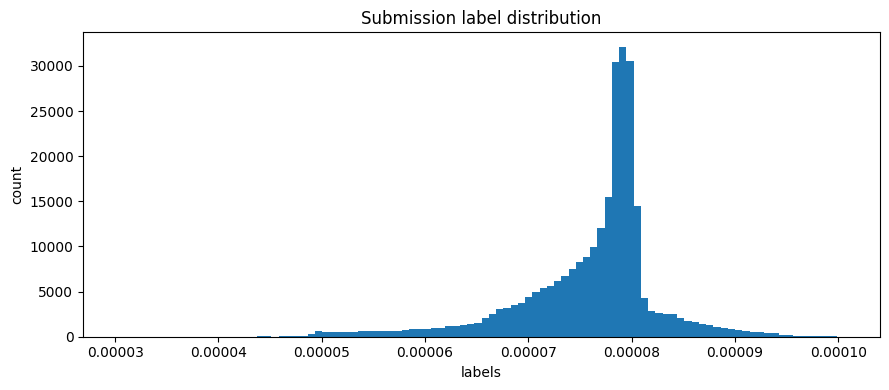

In [26]:
# === Run metadata + submission sanity ===
import json, platform, sys
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Collect metadata (best effort; fills None if var not in scope)
meta = {
    "cv_mean": float(np.mean(fold_corrs)) if 'fold_corrs' in globals() else None,
    "cv_std": float(np.std(fold_corrs)) if 'fold_corrs' in globals() else None,
    "last_fold_r": float(best_r) if 'best_r' in globals() else None,
    "best_iter_A": int(best_iter_A) if 'best_iter_A' in globals() else None,
    "best_iter_B": int(best_iter_B) if 'best_iter_B' in globals() else None,
    "seeds": list(SEEDS) if 'SEEDS' in globals() else None,
    "blend_w_global": float(best_w) if 'best_w' in globals() else None,
    "regime_feature": reg_name if 'reg_name' in globals() else None,
    "regime_threshold": float(thr) if 'thr' in globals() and thr is not None else None,
    "w_low": float(w_low) if 'w_low' in globals() else None,
    "w_high": float(w_high) if 'w_high' in globals() else None,
    "smoothing_window": int(w_opt) if 'w_opt' in globals() else 1,
    "n_features": int(len(feature_cols)) if 'feature_cols' in globals() else None,
    "python": sys.version.split()[0],
    "platform": platform.platform(),
}

out_json = Path("/kaggle/working/run_config.json")
out_json.write_text(json.dumps(meta, indent=2))
print("Saved run_config.json")
print(json.dumps(meta, indent=2))

# Load submission and sanity check
sub_path = Path("/kaggle/working/submission.csv")
assert sub_path.exists(), f"Missing {sub_path}"
s = pd.read_csv(sub_path)

print("\nSubmission:")
print("shape:", s.shape, "| columns:", s.columns.tolist())
print("NaNs:", int(s.isna().sum().sum()), "| zeros:", int((s['labels']==0).sum()))
print("stats: min/mean/median/max/std =",
      float(s['labels'].min()),
      float(s['labels'].mean()),
      float(s['labels'].median()),
      float(s['labels'].max()),
      float(s['labels'].std()))
print("quantiles:", s['labels'].quantile([0.01,0.25,0.5,0.75,0.99]).to_dict())

# Quick histogram (single plot, default style per rules)
plt.figure(figsize=(9,4))
plt.hist(s['labels'].values, bins=100)
plt.title("Submission label distribution")
plt.xlabel("labels"); plt.ylabel("count")
plt.tight_layout(); plt.show()
